In [78]:
!pip install langchain langgraph langchain-google-genai langchain-core langchain-community langchain-experimental fpdf pdfplumber

In [79]:
from langchain_core.runnables import RunnableConfig
from langchain.schema import AIMessage
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_community.agent_toolkits import FileManagementToolkit
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from pydantic import BaseModel, Field
from fpdf import FPDF
import random
import pdfplumber
import os
import requests
import warnings

warnings.filterwarnings("ignore")

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
google_api_key = "" # @param {"type":"string"}
tavily_api_key = "" # @param {"type":"string"}

In [82]:
os.environ["google_api_key"] = google_api_key
os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key

In [83]:
# 그래프 상태 정의

class State(TypedDict):
    query : Annotated[str, "User Question"]
    answer : Annotated[str, "LLM response"]
    messages : Annotated[list, add_messages]
    tool_call : Annotated[dict, "Tool Call Result"]

In [84]:
# LLM 정의

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                             temperature=0,
                             convert_system_message_to_human=True)

# llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
#                              temperature=0,
#                              convert_system_message_to_human=True)

In [85]:
@tool
def read_pdf(file_path: str):
    """
    PDF 파일에서 텍스트를 추출하는 도구입니다.
    표 형식 또는 일반 텍스트가 포함된 PDF를 읽고 문자열로 반환합니다.

    file_path 예시: './report.pdf'
    """
    try:
        text = ""
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
        return text.strip() if text.strip() else "❌ PDF에서 텍스트를 추출할 수 없습니다."
    except Exception as e:
        return f"❌ PDF 읽기 오류: {str(e)}"

In [86]:
@tool
def write_pdf(content: str, filename: str = "output.pdf", summary: bool =True):
    """
    텍스트를 PDF 파일로 저장하는 도구입니다.
    PDF형태의 문서로 만들어야할 때 이 도구를 사용하세요.
    """

    if summary:
        prompt = PromptTemplate.from_template("""
                당신은 보고서를 작성하는 어시스턴트입니다. 당신에겐 문서 모음이 제공되고 이를 잘 분석하여 보고서를 작성하여야 합니다.
                아래의 content는 문서 모음입니다. 문서의 제목, 본문을 잘 판단하고 정리하여 요약합니다.
                항상 구조화된 출력을 제공하세요.
                항상 마지막엔 인사이트도 첨부합니다.

                content : {content}
                """)

        chain = prompt | llm

        content = chain.invoke({"content":content}).content

    else:
        pass

    font_url = "https://github.com/google/fonts/raw/main/ofl/notosanskr/NotoSansKR%5Bwght%5D.ttf"
    font_path = "./fonts/NotoSansKR.ttf"

    try:
        os.mkdir("./fonts/")
        response = requests.get(font_url)
        with open(font_path, "wb") as f:
            f.write(response.content)
    except:
        pass

    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    font_path = "./fonts/NotoSansKR.ttf"  # <-- 여기에 실제 폰트 파일이 있어야 함

    try:
        pdf.add_font("NotoSans", "", font_path, uni=True)
        pdf.set_font("NotoSans", size=12)
    except:
        raise ValueError("한글 폰트를 등록할 수 없습니다.")

    for line in content.split("\n"):
        pdf.multi_cell(0, 10, line)
    pdf.output(f"./{filename}")

    return f"{filename} 저장 완료"

In [87]:
# 툴 정의
# TavilySearchResults : 웹 검색 도구
# PythonAstREPLTool : 파이썬 코드 실행 도구
# write_pdf : pdf 생성 도구
# read_pdf : pdf 읽기 도구
# file_delete : 파일 삭제 도구
# list_directory : 파일 목록 읽기 도구

tools = [TavilySearchResults(max_results=10), PythonAstREPLTool(), write_pdf, read_pdf, *FileManagementToolkit(
                                                                            selected_tools=["file_delete","list_directory"]).get_tools()]
search_tool, code_tool, write_tool, read_tool, delete_tool, listdir_tool= tools

In [88]:
# PDF 쓰기 도구 예시

write_tool.invoke({"content":"안녕하세요! \nZeroOne Report Agent 예제코드입니다.", "filename":"ZeroOne_report.pdf", "summary":False})

'ZeroOne_report.pdf 저장 완료'

In [89]:
# PDF 읽기 도구 예시

print("\n\n", read_tool.invoke("ZeroOne_report.pdf"))



 안녕하세요!
ZeroOne Report Agent 예제코드입니다.


In [90]:
# 파일 목록 도구 예시

print(listdir_tool.invoke(input=""))

.config
fonts
drive
.ipynb_checkpoints
ZeroOne_report.pdf
sample_data


In [91]:
# 삭제 도구 예시

delete_tool.invoke("ZeroOne_report.pdf")

'File deleted successfully: ZeroOne_report.pdf.'

In [92]:
# LLM에게 도구 할당

llm_with_tools = llm.bind_tools(tools)

In [93]:
# 전체 메시지 중 마지막 메시지를 제외하고 최대 8개까지 단기 기억(history)으로 추출

def shorterm_memory(state:State):

    if len(state["messages"]) > 8:
        history = state["messages"][-8:-1]
    elif len(state["messages"]) == 1:
        history = ""
    else:
        history = state["messages"][:-1]

    return history

In [94]:
class HistoryChecker(BaseModel):
    """
    이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
    답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.
    """

    yes_no : Literal["yes", "no"] = Field(..., description="""Use your previous conversation history to determine if you can answer your questions.
    Return "yes" if you can answer, "no" if you can't answer.""")

In [95]:
# 히스토리 기반 답변 분기를 위한 함수 설정

def history_check(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변할 수 있는지 판단합니다.
                답변할 수 있다면 "yes", 답변할 수 없다면 "no"를 반환합니다.

                대화 기록 : {history}

                질문 : {query}

                """)

    chain = prompt | history_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history":history,
                            "query":state["query"]})

    return result.yes_no

In [96]:
# LLM의 응답을 HistoryChecker 클래스 구조에 맞춰 파싱하도록 설정

history_checker = llm.with_structured_output(HistoryChecker)

In [97]:
# 기억 기반 답변 노드

def memory_chat(state:State):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                대화 기록을 통해 답변이 어렵다면 내부 지식을 참조하세요.

                대화 기록 : {history}

                질문 : {query}

                """)


    chain = prompt | llm

    history = shorterm_memory(state)

    result = chain.invoke({"history":history,
                           "query":state["query"]})

    if len(state["tool_call"]) == 0:
        return {"answer":result.content,
                "messages":result,
                "tool_call":"사용된 기록 없음."}
    else:
        return {"answer":result.content,
                "messages":result}

In [98]:
# 기억 기반 답변 분기 노드

def history_node(state:State):
    if len(state["messages"]) == 1:
        return {"answer":"답변 없음",
                "tool_call":"사용된 도구 없음"}
    else:
        return state

In [99]:
# 도구 선택 노드

def select(
    state: State,
):

    prompt = PromptTemplate.from_template("""

                이전의 대화 기록을 참고하여 질문에 대해 답변하세요.
                아래 대화 기록을 첨부합니다.
                이전의 대화가 다음에 어떤 도구를 사용해야하는지 힌트가 될 수 있습니다. 꼭 참조하세요.
                도구의 변화가 큰 결과를 가져올 수 있습니다.
                들어온 메시지, 정답, 이전 기록을 모두 분석하여 가장 적절한 도구를 선택하세요.

                대화 기록 : {history}

                최근 사용한 도구 : {tool_name}

                정답 : {answer}

                질문 : {query}

                """)

    chain = prompt | llm_with_tools

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                           "tool_name" : state["tool_call"],
                            "answer": state["answer"],
                            "query": state["query"]})

    if hasattr(result, "tool_calls") and len(result.tool_calls) > 0:
        tool_calls = result.tool_calls

        return {"messages": result,
                "tool_call":tool_calls}
    else:
        return {"messages":AIMessage(content=f"""도구를 선택하지 못했습니다. 적절한 도구를 재선택하세요.
                                        """),
                                    "tool_call":"선택된 도구 없음"}



In [100]:
# 도구 실행 노드

tool_node = ToolNode(tools)

In [101]:
class AnswerChecker(BaseModel):
    """
    정답 분류기입니다.

    정답이 질문을 해결했는지 여부를 판단합니다.
    질문을 해결하지 못했을 시 해결될 때까지 도구를 이용합니다.

    질문을 해결했다면 "end", 해결하지 못했다면 "tool"을 반환합니다.
    """


    end : Literal["end", "tool"] = Field(..., description="""You are the answer sorter.

                                                                Determine if the correct answer has solved the question.
                                                                If the question is not resolved, use the tool until it is resolved.

                                                                Return "end" if you solved the question, or "tool" if you didn't.""")

In [102]:
# LLM의 응답을 AnswerChecker 클래스 구조에 맞춰 파싱하도록 설정

answer_checker = llm.with_structured_output(AnswerChecker)

In [103]:
# 답변 확인 노드

def response(state:State):

    return {"answer":state["messages"][-1]}

In [104]:
# 답변 완성 판단 분기 함수

def answer_check(state:State):

    prompt = PromptTemplate.from_template("""
    당신은 정답 분류기 어시스턴트입니다.

    정답이 질문을 해결하였는지 여부를 판단합니다.
    질문을 해결하지 못했다면 도구를 이용합니다.

    질문을 해결하였다면 "end", 아니라면 "tool"을 반환합니다.

    기존 History도 참고하여 답변하세요.

    History : {history}

    정답 : {answer}

    질문 : {query}
    """)

    chain = prompt | answer_checker

    history = shorterm_memory(state)

    result = chain.invoke({"history" : history,
                            "answer": state["answer"],
                            "query": state["query"]})

    return result.end

In [105]:
# 그래프 정의

graph_builder = StateGraph(State)

In [106]:
# 노드 및 엣지 정의

graph_builder.add_node("history_node", history_node)
graph_builder.add_node("memory_chat", memory_chat)
graph_builder.add_node("select", select)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("response", response)


graph_builder.add_edge(START, "history_node")
graph_builder.add_conditional_edges("history_node",
                            history_check,
                            {"yes":"memory_chat",
                             "no":"select"})
graph_builder.add_edge("select", "tools")
graph_builder.add_edge("tools", "response")
graph_builder.add_edge("memory_chat", "response")
graph_builder.add_conditional_edges("response",
                                    answer_check,
                                    {"end":END,
                                    "tool":"select"});

In [107]:
# 메모리 설정 및 그래프 컴파일

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

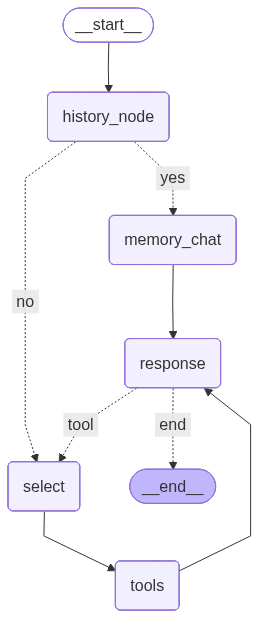

In [108]:
# 그래프 시각화
# 가끔 "ReadTimeout: HTTPSConnectionPool(host='mermaid.ink', port=443): Read timed out. (read timeout=10)"라는 에러가 발생
# 시간 초과로 그래프 생성에 실패했다는 메시지일뿐 기능과는 관계없으니 진행해도 괜찮습니다.

graph

In [109]:
# config 재생성 노드, config의 재사용은 고려되지 않음. 재사용한다면 변수에 할당하여 사용할 것

def reset_config(limit=20):

    thread_id=random.randint(1,999999)

    config = RunnableConfig(recursion_limit=limit, configurable={"thread_id": thread_id})

    return config

In [110]:
# 출력 함수 정의
# mode = "values" : 상태의 키, 값의 형태로 반환
# mode = "updates" : 업데이트되는 값만 반환

def streaming(query, config, mode="values"):

    result = graph.stream({"messages":("user", query),
                         "query":query}, config=config, stream_mode=mode)

    if mode == "values":
        for step in result:
            for k, v in step.items():
                if k == "messages":
                    v[-1].pretty_print()
    elif mode == "updates":
        for step in result:
            for k,v in step.items():
                print(f"\n\n=== {k} ===\n\n")
                print(v)

    return

In [111]:
config = reset_config()

query = "1+1은 뭔가요?"

streaming(query, config)

================================ Human Message =================================

1+1은 뭔가요?
================================ Human Message =================================

1+1은 뭔가요?
================================== Ai Message ==================================

2
================================== Ai Message ==================================

2


In [112]:
config = reset_config()

query = "현대자동차라는 회사에 대해 조사해주세요. 잘 정리된 보고서를 제공해주십시오. pdf 포멧의 파일로 받기를 희망합니다."

streaming(query, config)

================================ Human Message =================================

현대자동차라는 회사에 대해 조사해주세요. 잘 정리된 보고서를 제공해주십시오. pdf 포멧의 파일로 받기를 희망합니다.
================================ Human Message =================================

현대자동차라는 회사에 대해 조사해주세요. 잘 정리된 보고서를 제공해주십시오. pdf 포멧의 파일로 받기를 희망합니다.
================================== Ai Message ==================================

현대자동차에 대한 보고서를 PDF 형식으로 제공해 드리겠습니다. 먼저, 현대자동차에 대한 정보를 검색하고, 이를 바탕으로 보고서를 작성한 다음, PDF 파일로 저장하겠습니다.
Tool Calls:
  tavily_search_results_json (beb797c4-54d7-477c-b479-aec74aff7048)
 Call ID: beb797c4-54d7-477c-b479-aec74aff7048
  Args:
    query: 현대자동차
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Hyundai Motor Company", "url": "https://en.wikipedia.org/wiki/Hyundai_Motor_Company", "content": "Hyundai Motor Company, often referred to as Hyundai Motors (Korean:현대자동차listenⓘ) and commonly known as Hyundai (현대; ( \"Help:IPA/Korean\")( 'modern

In [113]:
query = "현대자동차의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요."

streaming(query, config)

================================ Human Message =================================

현대자동차의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요.
================================ Human Message =================================

현대자동차의 경쟁사에 대한 정보도 정리된 보고서를 작성해주세요.
================================== Ai Message ==================================

현대자동차의 경쟁사에 대한 정보를 검색하고, 이를 바탕으로 보고서를 작성한 다음, PDF 파일로 저장하겠습니다.
Tool Calls:
  tavily_search_results_json (5a6c1835-0bba-45c0-bbdf-bd365aa15f05)
 Call ID: 5a6c1835-0bba-45c0-bbdf-bd365aa15f05
  Args:
    query: 현대자동차 경쟁사
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "현대자동차 - 나무위키", "url": "https://namu.wiki/w/%ED%98%84%EB%8C%80%EC%9E%90%EB%8F%99%EC%B0%A8", "content": "내수 시장에서는 기아를 제외한 나머지 경쟁사인 KG모빌리티, 르노코리아, GM 한국사업장 대비 비슷하거나 저렴한 가격에 더 우수한 상품성을 자랑하며 넓은 실내공간과 풍부한 옵션이 특징이다. 1.6~ 5.0L 가솔린 엔진, 2.0~3.5L LPi 엔진, 1.6~3.0L 디젤 엔진, 수소, 전기 등 다양한 연료 사용가능성과 염가패키지로 택시, 렌터카, 관공서등 플릿시장에서 또한 높은 시장지배력을 지니고 있다. [...

In [114]:
#config = reset_config()

#query = "현재 폴더의 pdf로 이루어진 파일 모두 삭제해줘"

#streaming(query, config)

In [115]:
config = reset_config()

code = """
아래 코드 실행시켜주세요.

```python

result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i+1)
    result += i

print("최종 결과: ", result)

```
"""

streaming(code, config)

================================ Human Message =================================


아래 코드 실행시켜주세요.

```python

result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i+1)
    result += i

print("최종 결과: ", result)

```

================================ Human Message =================================


아래 코드 실행시켜주세요.

```python

result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i+1)
    result += i

print("최종 결과: ", result)

```

================================== Ai Message ==================================
Tool Calls:
  python_repl_ast (e5cd14ae-4560-4045-b93b-858a40fc7a84)
 Call ID: e5cd14ae-4560-4045-b93b-858a40fc7a84
  Args:
    query: 
result = 0

for i in range(20):
    print(f"{i+1}번째 출력: ", i+1)
    result += i

print("최종 결과: ", result)
1번째 출력:  1
2번째 출력:  2
3번째 출력:  3
4번째 출력:  4
5번째 출력:  5
6번째 출력:  6
7번째 출력:  7
8번째 출력:  8
9번째 출력:  9
10번째 출력:  10
11번째 출력:  11
12번째 출력:  12
13번째 출력:  13
14번째 출력:  14
15번째 출력:  15
16번째 출력:  16
17번째 출력:  17
18번째 출력:  18
19번째 출력:  19
20번째

In [116]:
config = reset_config()

streaming("""
          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.""", config)

================================ Human Message =================================


          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.
================================ Human Message =================================


          모두의연구소는 어떤 곳이야?
          깔끔하게 정리해서 레포트로 만들어줘.
          레포트의 형식은 pdf로 저장해주면 돼.
          이름은 "모두의연구소_레포트.pdf"로 해줘.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (05c3b7ba-f896-4034-ab4c-81cc1bd561a6)
 Call ID: 05c3b7ba-f896-4034-ab4c-81cc1bd561a6
  Args:
    query: 모두의연구소
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "스토리 | 모두의연구소", "url": "https://modulabs.co.kr/modulabs-story", "content": "### 언론 속의 모두의연구소\n\n### 김승일 모두의연구소 대표, 제5회 아이뉴스 DNA 공로상 수상\n\n제5회 아이뉴스24 D·N·A 혁신상' 시상식이 18일 서울 용산구 그랜드 하얏트 서울에서 열렸다. 김 대표는 모두의연구소를 통해 누구나 하고 싶은 연

In [117]:
#config = reset_config()

#query = "'모두의연구소_레포트.pdf'라는 파일 삭제해줘"

#streaming(query, config)